# Catalan Juvenile Justice - Data Processing 

In [2]:
import torch

import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

### Load dataset

First, the data is loaded...

In [3]:
DATA_PATH = "../../data" 
df = pd.read_csv(f"{DATA_PATH}/raw/catalan_data_course/catalan-juvenile-recidivism-subset.csv", header=0)

# Display dataframe head
df.head()

,id,V1_sex,V4_area_origin,V6_province,V8_age,V9_age_at_program_end,V11_criminal_record,V12_n_criminal_record,V13_n_crime_cat,V15_main_crime_cat,...,V28_days_from_crime_to_program,V29_program_duration,V115_RECID2015_recid,V10_date_of_birth_year,V10_date_of_birth_month,V22_main_crime_date_year,V22_main_crime_date_month,V30_program_start_year,V30_program_start_month,V31_program_end_month
0,691,male,Spain,Lleida,15,17,1,1-2,3+,Against People,...,587.0,132,1,1992,11,2008,8,2010,4,8
1,956,female,Spain,Barcelona,14,15,1,1-2,2,Against People,...,107.0,258,1,1995,7,2009,8,2009,12,8
2,2560,male,Maghreb,Barcelona,15,16,1,3-5,3+,Against People,...,135.0,85,1,1994,1,2009,11,2010,3,6
3,2018,male,Maghreb,Girona,14,15,1,5+,2,Against People,...,176.0,271,1,1994,4,2009,1,2009,6,3
4,1650,male,Spain,Tarragona,17,20,1,5+,3+,Against People,...,261.0,533,1,1990,9,2008,9,2009,5,11


Next, an overview of the columns contained is provided.

In [4]:
# Column overview
Counter(df.columns)

Counter({'id': 1,
         'V1_sex': 1,
         'V4_area_origin': 1,
         'V6_province': 1,
         'V8_age': 1,
         'V9_age_at_program_end': 1,
         'V11_criminal_record': 1,
         'V12_n_criminal_record': 1,
         'V13_n_crime_cat': 1,
         'V15_main_crime_cat': 1,
         'V16_violent_crime': 1,
         'V17_crime_classification': 1,
         'V19_committed_crime': 1,
         'V20_n_juvenile_records': 1,
         'V21_n_crime': 1,
         'V23_territory_of_execution': 1,
         'V24_finished_program': 1,
         'V26_finished_measure_grouped': 1,
         'V27_program_duration_cat': 1,
         'V28_days_from_crime_to_program': 1,
         'V29_program_duration': 1,
         'V115_RECID2015_recid': 1,
         'V10_date_of_birth_year': 1,
         'V10_date_of_birth_month': 1,
         'V22_main_crime_date_year': 1,
         'V22_main_crime_date_month': 1,
         'V30_program_start_year': 1,
         'V30_program_start_month': 1,
         'V31_progr

The attributes are of different types (nominal, ordinal, numerical) from which some of them are sensitive attributes (in terms of being fairness-related attributes). An overview of a potential mapping is provided below:

In [5]:
sensitive_attributes = [
    'V1_sex',
    'V4_area_origin',
    'V8_age',
    'V9_age_at_program_end',
    'V10_date_of_birth_year',
    'V10_date_of_birth_month',
]

numerical_cols = [
    'V20_n_juvenile_records',
    'V28_days_from_crime_to_program',
    'V29_program_duration',
    'V22_main_crime_date_year',
    'V22_main_crime_date_month',
    'V30_program_start_year',
    'V30_program_start_month',
    'V31_program_end_month',
]

ordinal_cols = [
    'V12_n_criminal_record',
    'V13_n_crime_cat',
    'V21_n_crime',
    'V27_program_duration_cat',    
]

cat_cols = [
    'V6_province',
    'V11_criminal_record',
    'V15_main_crime_cat',
    'V16_violent_crime',
    'V17_crime_classification',
    'V19_committed_crime',
    'V23_territory_of_execution',
    'V24_finished_program',
    'V26_finished_measure_grouped',
]

target = 'V115_RECID2015_recid'

# Check that shapes add up (disregarding the id columns)
assert df.columns.__len__() - 1 == len(sensitive_attributes) + len(numerical_cols) + len(ordinal_cols) + len(cat_cols) + 1

In [8]:
sensitive_cat_cols = np.setdiff1d(sensitive_attributes, df[sensitive_attributes]._get_numeric_data().columns)
df_corrplot = pd.get_dummies(df[[target] + ['V8_age', 'V1_sex', 'V4_area_origin']], columns=sensitive_cat_cols)

<Figure size 1000x1000 with 0 Axes>

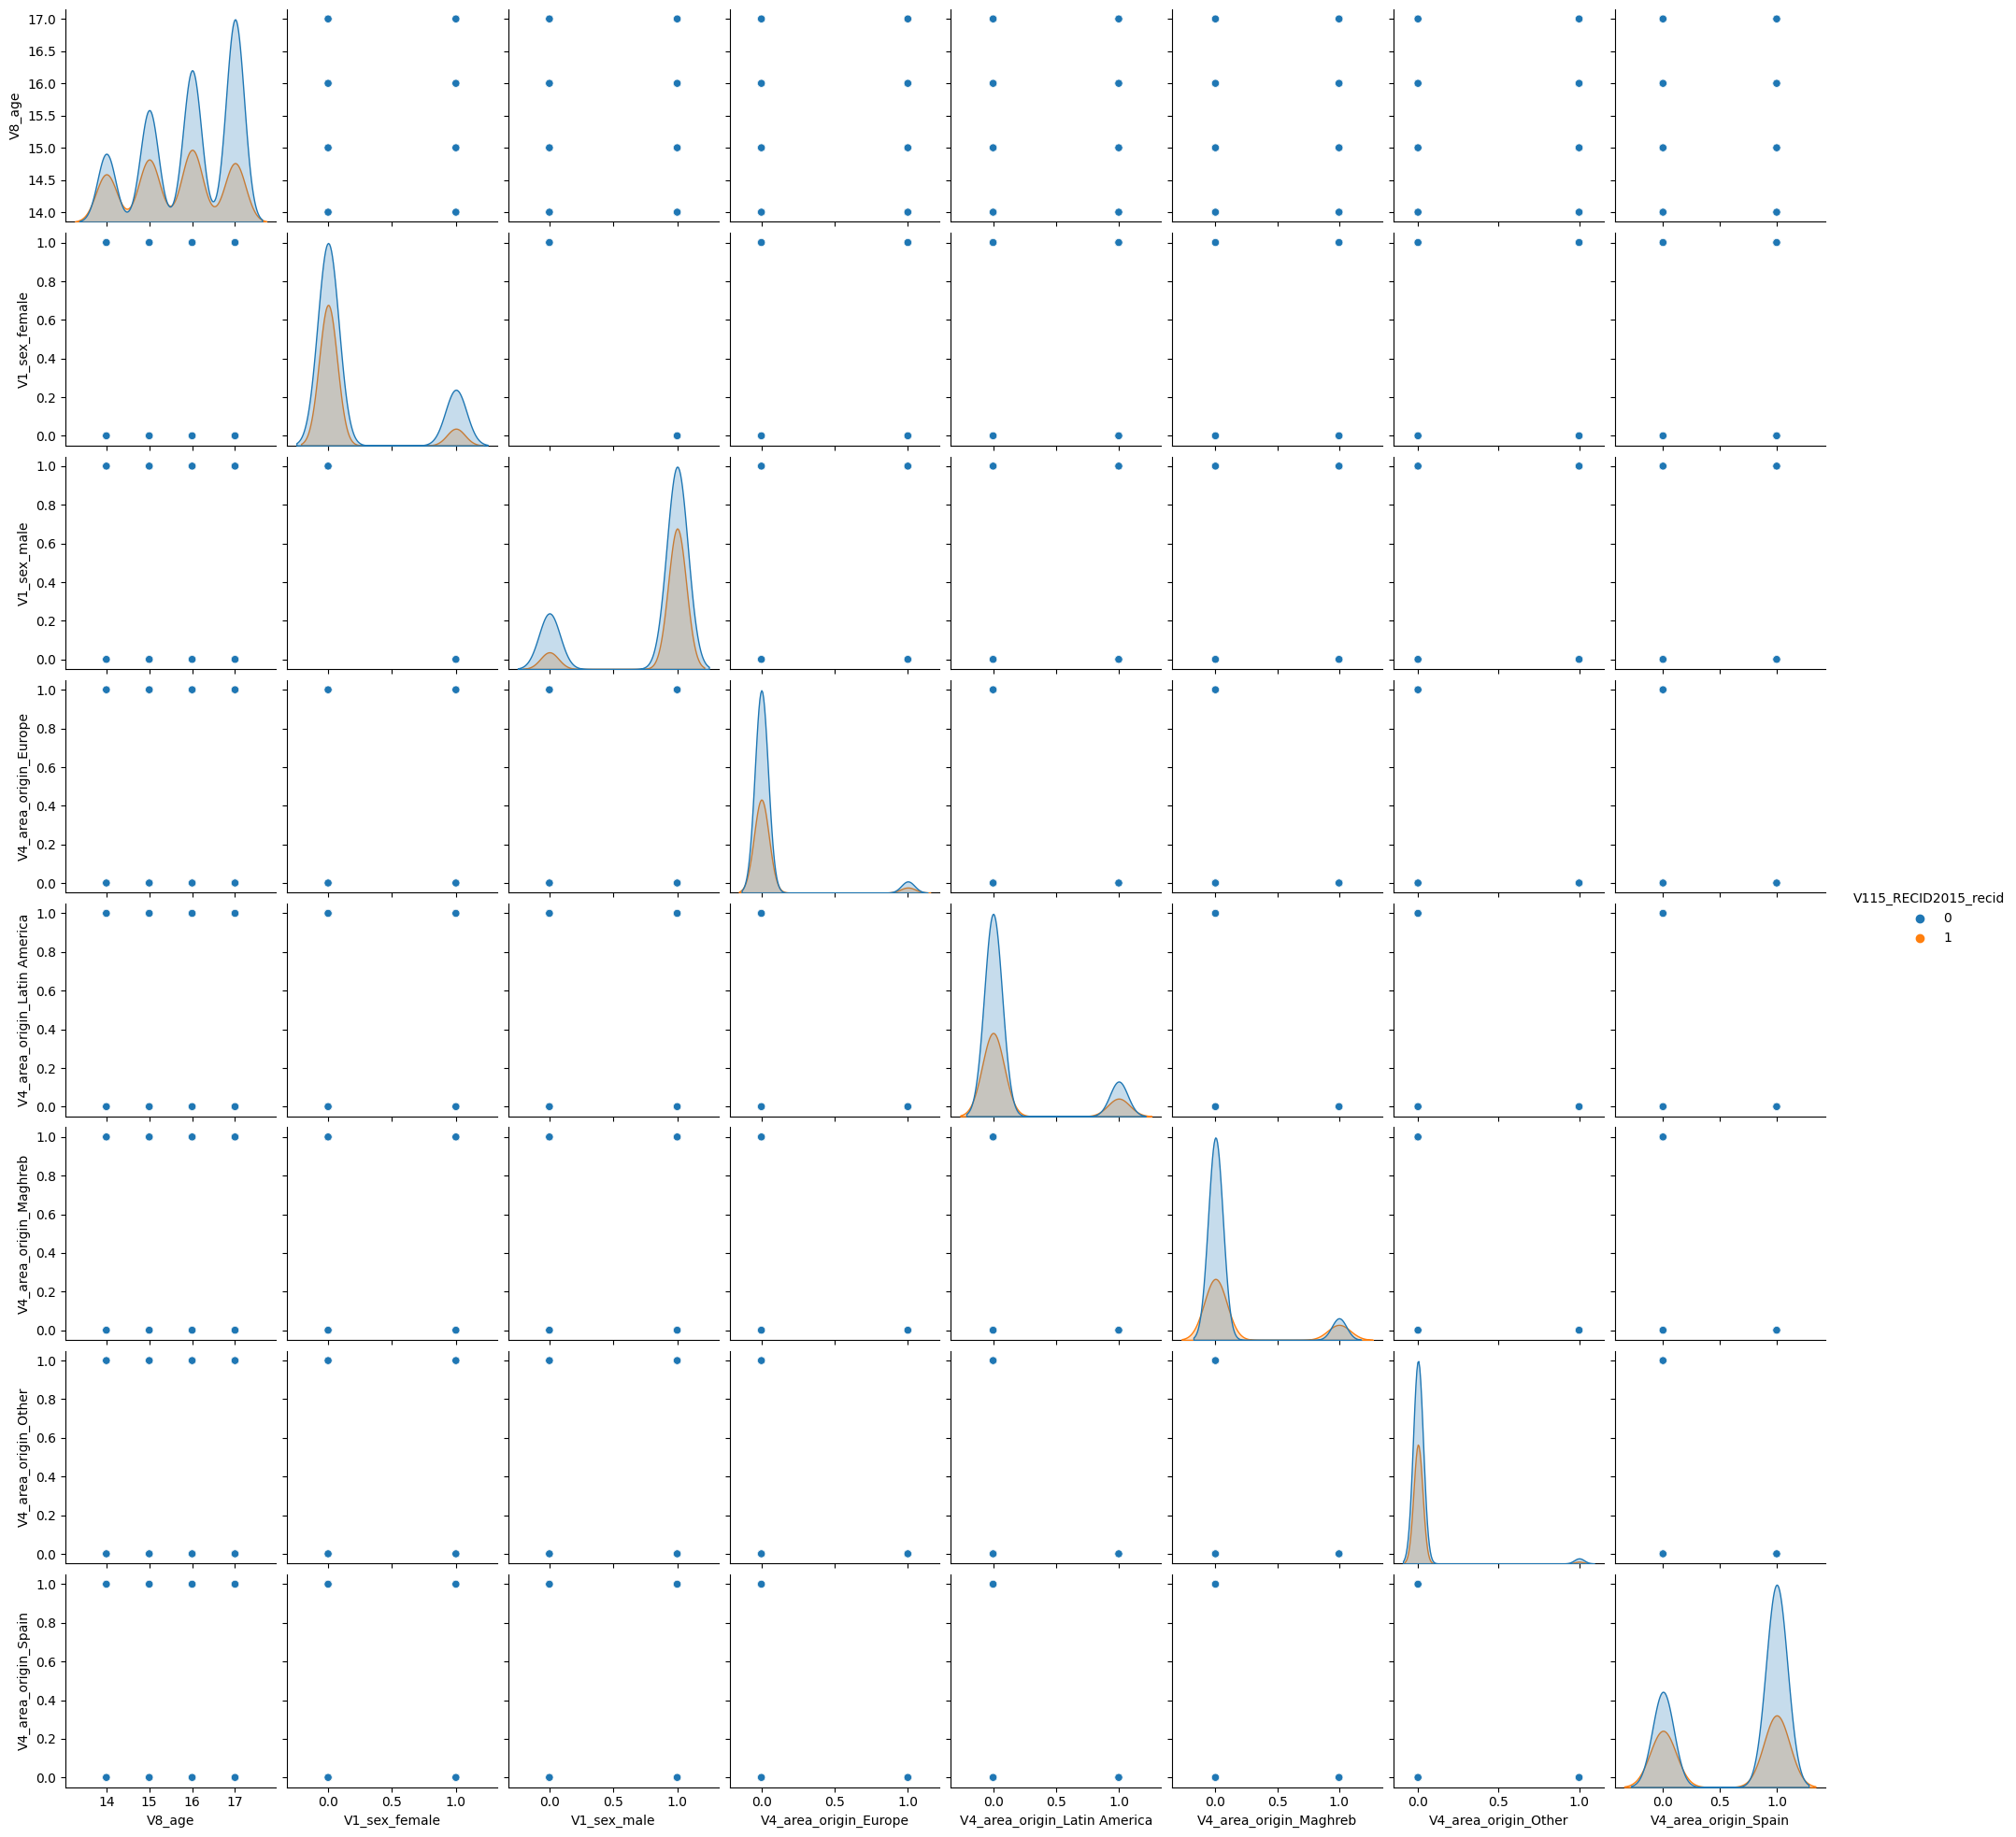

In [12]:
fig = plt.figure(figsize=(10, 10))
sns.pairplot(df_corrplot, hue=target)
plt.show()

For the ordinal attributes we need to map the string content to numerical ordered data. An overview of the mappings are provided below.

In [28]:
# Ordinal mappings
mappings = {
    'V12_n_criminal_record': {'0': 0, '1-2': 1, '3-5': 2, '5+': 3},
    'V13_n_crime_cat': {'1': 1, '2': 2, '3+': 3},
    'V27_program_duration_cat': {'<6 months': 0, '6 months < 1 year': 1, '>1 year': 2}
}

Now, we have all information for modifying the dataframe to only contain numerical input, which will be necessary when training a Neural Network. The categorical data is one-hot-encoded along wit the binary target attribute, whereas the ordinal attributes are numericalized using the previously defined mappings: 

In [29]:
# Replace ordinal values with the specified mappings
for col in ordinal_cols:
    if col in mappings.keys():
        reverse_mapping = {v: k for k, v in mappings[col].items()}
        df[col] = df[col].astype('category').replace(mappings[col])
        df[col] = df[col].cat.rename_categories(reverse_mapping)
        df[col] = df[col].cat.codes

# Categorical attributes
df = pd.get_dummies(
    df,
    columns=cat_cols,
)

df[target] = df[target].astype('category').cat.rename_categories({0: 'No', 1: 'Yes'})

For a better workflow in the dataloader, the dataset is split into `data`, `labels` and `sensitive_data`. 

In [35]:
labels          = df[target].cat.codes
sensitive_data  = pd.get_dummies(df[sensitive_attributes])
data            = pd.get_dummies(df, columns=sensitive_attributes[:2]).drop(columns=[target] + ['id'])# + sensitive_attributes)

Now, the processed datafile is constructed as a dictionary and saved as a `torch`-pickle. 

#### Dataset with sensitive attributes excluded

In [40]:
labels          = df[target].cat.codes
sensitive_data  = pd.get_dummies(df[sensitive_attributes])
data            = df.drop(columns=[target] + ['id'] + sensitive_attributes)

# Setup datafile structure
datafile = {
    'data': {
        'columns': np.array(data.columns),
        'content': data.to_numpy(),
    },
    'labels': {
        'name': target,
        'content': labels.to_numpy().reshape(-1, 1), 
    },
    'sensitive_attributes': {
        'name': (sensitive_data.columns),
        'content': sensitive_data.to_numpy(),
    },
    'attribute_information': {
        'numerical_columns': numerical_cols,
        'ordinal_columns': ordinal_cols,
        'categorical_columns': cat_cols,
        'sensitive_attributes': sensitive_attributes,
    }
}

# Save datafile
filename = 'catalan_dataset.pth'
torch.save(datafile, f"{DATA_PATH}/processed/{filename}")

In [41]:
print(f"Data shape: \t\t{datafile['data']['content'].shape}")
print(f"Label shape: \t\t{datafile['labels']['content'].shape}")
print(f"Sensitive data shape: \t{datafile['sensitive_attributes']['content'].shape}")

Data shape: 		(4652, 73)
Label shape: 		(4652, 1)
Sensitive data shape: 	(4652, 11)


#### Dataset with sensitive attributes included

In [42]:
labels          = df[target].cat.codes
sensitive_data  = pd.get_dummies(df[sensitive_attributes])
data            = pd.get_dummies(df, columns=sensitive_attributes[:2]).drop(columns=[target] + ['id'])

# Setup datafile structure
datafile = {
    'data': {
        'columns': np.array(data.columns),
        'content': data.to_numpy(),
    },
    'labels': {
        'name': target,
        'content': labels.to_numpy().reshape(-1, 1), 
    },
    'sensitive_attributes': {
        'name': (sensitive_data.columns),
        'content': sensitive_data.to_numpy(),
    },
    'attribute_information': {
        'numerical_columns': numerical_cols,
        'ordinal_columns': ordinal_cols,
        'categorical_columns': cat_cols,
        'sensitive_attributes': sensitive_attributes,
    }
}

# Save datafile
filename = 'biased_catalan_dataset.pth'
torch.save(datafile, f"{DATA_PATH}/processed/{filename}")

In [43]:
print(f"Data shape: \t\t{datafile['data']['content'].shape}")
print(f"Label shape: \t\t{datafile['labels']['content'].shape}")
print(f"Sensitive data shape: \t{datafile['sensitive_attributes']['content'].shape}")

Data shape: 		(4652, 84)
Label shape: 		(4652, 1)
Sensitive data shape: 	(4652, 11)


### Test custom `torch` DataLoader

In [42]:
from src.data.dataloader import CatalanJuvenileJustice

dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_PATH}/processed/catalan_dataset.pth"
)

train_loader, val_loader, test_loader = dataset.get_loaders(
    batch_size=128, shuffle=True, num_workers=1, 
    test_size=0.2, val_size=0.2, split_type='random',
)


try:
    # Checking that the dataloader works...
    for i, batch in enumerate(train_loader, 0):
        data_, label_ = batch['data'], batch['label']

    print("Successfully looped through the DataLoader!")

except KeyError as e:
    raise e

Successfully looped through the DataLoader!


### Test seed functionality

In [43]:
def set_seed(seed: int):
    torch.manual_seed(seed)

First in a setting for two dataloaders using the same seed which should give same splits...

In [44]:
set_seed(41)
train_loader1, val_loader1, test_loader1 = dataset.get_loaders(
    batch_size=128, shuffle=True, num_workers=1, 
    test_size=0.2, val_size=0.2, split_type='random',
)

set_seed(41)
train_loader2, val_loader2, test_loader2 = dataset.get_loaders(
    batch_size=128, shuffle=True, num_workers=1, 
    test_size=0.2, val_size=0.2, split_type='random',
)

# Should give same splits
assert train_loader1.dataset.indices == train_loader2.dataset.indices
assert val_loader1.dataset.indices == val_loader2.dataset.indices
assert test_loader1.dataset.indices == test_loader2.dataset.indices

Next, when using different seeds, we should get different splits...

In [45]:
set_seed(0)
train_loader1, val_loader1, test_loader1 = dataset.get_loaders(
    batch_size=128, shuffle=True, num_workers=1, 
    test_size=0.2, val_size=0.2, split_type='random',
)

set_seed(41)
train_loader2, val_loader2, test_loader2 = dataset.get_loaders(
    batch_size=128, shuffle=True, num_workers=1, 
    test_size=0.2, val_size=0.2, split_type='random',
)

# Should give non-identical splits
assert train_loader1.dataset.indices != train_loader2.dataset.indices
assert val_loader1.dataset.indices != val_loader2.dataset.indices
assert test_loader1.dataset.indices != test_loader2.dataset.indices

### Label distribution 

In [46]:
# Label distribution
counts = Counter(df[target].cat.codes)
sorted({k: np.round(v / sum(counts.values()), 4) for k, v in counts.items()}.items(), key=lambda x: x[0])

[(0, 0.6574), (1, 0.3426)]

## Train model (temporary)

In [47]:
from src.models.model import FullyConnected, get_loss_function, get_optimizer

model = FullyConnected(channels_in = dataset.n_attributes, channels_out = 2)
criterion = get_loss_function(type='BCE')
optimizer = get_optimizer(model, type='Adam')

In [48]:
# Label distribution
counts = Counter(df[target].cat.codes)
sorted({k: np.round(v / sum(counts.values()), 4) for k, v in counts.items()}.items(), key=lambda x: x[0])

[(0, 0.6574), (1, 0.3426)]